<a href="https://colab.research.google.com/github/r-isachenko/2022-2023-DGM-MIPT-course/blob/main/seminars/seminar8/GAN_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from time import time
import torch
from torch import nn
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
import torch.distributions as TD

from IPython import display

# <center>Deep Generative Models</center>
## <center>Seminar 8</center>

<!-- <center><img src="pics/AIMastersLogo.png" width=600 /></center> -->
<center>14.02.23</center>

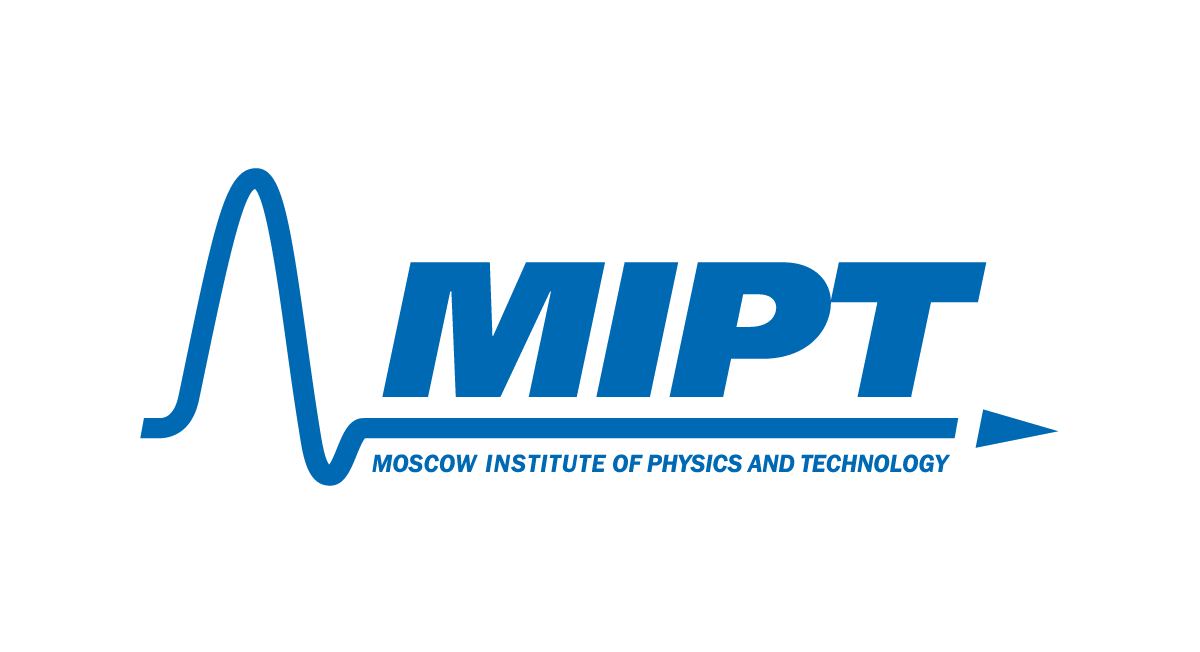

In [2]:
# display.Image("pics/mipt_logo.png", width=1000)

## Plan

1. Vanilla GAN

# Vanilla GAN

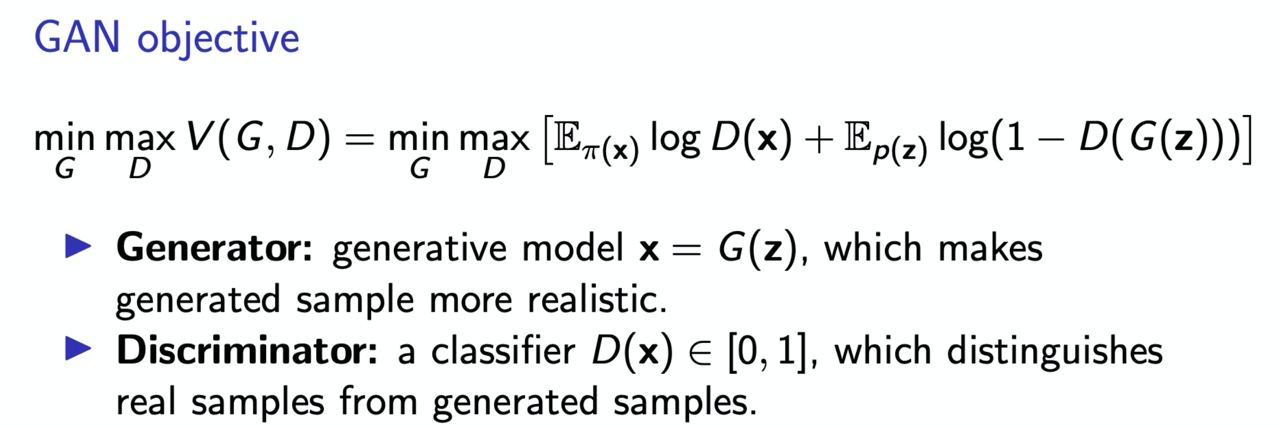

In [20]:
# display.Image("pics/gan_objective.jpg", width=1000)

<!-- <img src="pics/gan_objective.jpg" width=800 height=800 /> -->

In [41]:
def get_simple_model(hiddens):
    assert len(hiddens) > 1

    modules = []
    for in_, out_ in zip(hiddens[:-2], hiddens[1:-1]):
        modules.extend([nn.Linear(in_, out_), nn.ReLU()])

    modules.append(nn.Linear(hiddens[-2], hiddens[-1]))

    return nn.Sequential(*modules)

In [10]:
# define Generator and Discriminator NNs
gen_hiddens = [1, 64, 64, 64, 1]
dis_hiddens = [1, 64, 64, 64, 1]

### YOUR CODE HERE

In [43]:
####

In [44]:
mu = 2
noise_fn = lambda x: torch.rand((x, 1), device='cpu')-2 # samples latent distribution of generator
data_fn = lambda x: mu + torch.randn((x, 1), device='cpu') # samples from the distribution of interest 
data_pdf = lambda X: norm.pdf(X-mu) # pdf of the distribution of interest

In [45]:
def plot_gan_data(data_fn, noise_fn, data_pdf=None):
    noise = noise_fn(5000).numpy().flatten()
    target = data_fn(5000).numpy().flatten()

    plt.hist(noise, label='noise', alpha=0.5, density=True, color='b')
    plt.hist(target, label='target', alpha=0.5, density=True, color='g')
    if data_pdf is not None:
        x = np.linspace(-6,6,100)
        plt.plot(x, data_pdf(x), 'g', label='real distibution')

    plt.legend(loc='upper left')
    plt.show()

In [11]:
plot_gan_data(data_fn, noise_fn, data_pdf)

In [47]:
class VanillaGAN():
    def __init__(self, G, D, noise_fn, data_fn,
                 batch_size=32, device='cpu', lr_D=1e-3, lr_G=2e-4):
        """A GAN class for holding and training a generator and discriminator
        Args:
            G: a Ganerator network
            D: A Discriminator network
            noise_fn: function f(num: int) -> pytorch tensor, (latent vectors)
            data_fn: function f(num: int) -> pytorch tensor, (real samples)
            batch_size: training batch size
            device: cpu or CUDA
            lr_D: learning rate for the discriminator
            lr_G: learning rate for the generator
        """
        self.G = G
        self.G = self.G.to(device)
        self.D = D
        self.D = self.D.to(device)
        self.noise_fn = noise_fn
        self.data_fn = data_fn
        self.batch_size = batch_size
        self.device = device
        # !
        self.criterion = nn.BCELoss()
        self.optim_D = optim.Adam(D.parameters(),
                                  lr=lr_D, betas=(0.5, 0.999))
        self.optim_G = optim.Adam(G.parameters(),
                                  lr=lr_G, betas=(0.5, 0.999))
        # is needed in D train loop
        self.target_ones = torch.ones((batch_size, 1)).to(device)
        self.target_zeros = torch.zeros((batch_size, 1)).to(device)
    
    def generate_samples(self, latent_vec=None, num=None):
        """Sample from the generator.
        Args:
            latent_vec: A pytorch latent vector or None
            num: The number of samples to generate if latent_vec is None
        If latent_vec and num are None then us self.batch_size random latent
        vectors.
        ! We don't need grad for generated samples
        """
        num = self.batch_size if num is None else num
        latent_vec = self.noise_fn(num) if latent_vec is None else latent_vec
        ### YOUR CODE HERE
        samples = []
        return samples

    def train_step_G(self):
        """Train the generator one step and return the loss."""
        self.G.zero_grad()
        latent_vec = self.noise_fn(self.batch_size)
        # YOUR CODE HERE
        # use self.target_ones
        loss = torch.tensor(0.)
        return loss.item()

    def train_step_D(self):
        """Train the discriminator one step and return the losses."""
        self.D.zero_grad()

        # real samples
        real_samples = self.data_fn(self.batch_size)
        # calc real loss
        # YOUR CODE HERE
        
        loss_real = torch.tensor(0.)

        # generated samples
        latent_vec = self.noise_fn(self.batch_size)
        # calc fake loss
        # you shouldn't optimize G here
        # YOUR CODE HERE
        
        loss_fake = torch.tensor(0.)

        # combine
        loss = (loss_real + loss_fake) / 2
        loss.backward()
        self.optim_D.step()

        return loss_real.item(), loss_fake.item()

    def train_step(self):
        """Train both networks and return the losses."""
        loss_D = self.train_step_D()
        loss_G = self.train_step_G()
        return loss_G, loss_D

In [72]:
gen_hiddens = [1, 64, 64, 64, 1]
dis_hiddens = [1, 64, 64, 64, 1]
G = get_simple_model(gen_hiddens)
D = nn.Sequential(*get_simple_model(dis_hiddens), nn.Sigmoid())

gan = VanillaGAN(G, D, noise_fn, data_fn, device='cpu')

In [73]:
def visualize_GAN(gan, data_pdf=None):
    size = 500
    x = np.linspace(-6,6,100)
    bins = np.linspace(-6,6,60)
    real_data = gan.data_fn(size)
    noise = gan.noise_fn(size)
    sampled_data = gan.generate_samples(noise)
    
    plt.hist(noise.numpy(), label='noise', alpha=0.5, density=True, color='b', bins=bins)
    plt.hist(real_data.numpy(), label='real data', alpha=0.5, density=True, color='g', bins=bins)
    plt.hist(sampled_data.numpy(), label='G samples', alpha=0.5, density=True, color='r', bins=bins)
    
    if data_pdf is not None:
        plt.plot(x, data_pdf(x), 'g', label='real distibution')
    with torch.no_grad():
        plt.plot(x, gan.D(torch.from_numpy(x).float().unsqueeze(-1)).numpy(), 'b', label='D distibution')
    
    plt.legend(loc='upper left')
    plt.show()

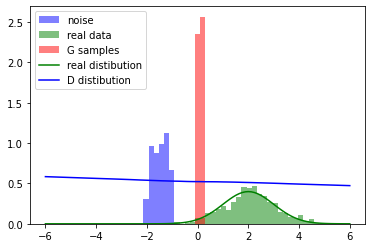

In [74]:
visualize_GAN(gan, data_pdf=data_pdf)

In [91]:
epochs = 40
batches = 100

In [92]:
step_size = 1
loss_g, loss_d_real, loss_d_fake = [], [], []
start = time()
for epoch in range(epochs):
    break
    loss_g_running, loss_d_real_running, loss_d_fake_running = 0, 0, 0
    for i,batch in enumerate(range(batches)):
        #lg_, (ldr_, ldf_) = gan.train_step()
        ldr_, ldf_ = gan.train_step_D()
        if i%step_size == 0:
            print(i)
            print('D train step')
            visualize_GAN(gan)
        lg_ = gan.train_step_G()
        if i%step_size == 0:
            print('G train step')
            visualize_GAN(gan)

        loss_g_running += lg_
        loss_d_real_running += ldr_
        loss_d_fake_running += ldf_
    loss_g.append(loss_g_running / batches)
    loss_d_real.append(loss_d_real_running / batches)
    loss_d_fake.append(loss_d_fake_running / batches)
    print(f"Epoch {epoch+1}/{epochs} ({int(time() - start)}s):"
          f" G={loss_g[-1]:.3f},"
          f" Dr={loss_d_real[-1]:.3f},"
          f" Df={loss_d_fake[-1]:.3f}")
    visualize_GAN(gan, data_pdf=data_pdf)

In [61]:
######

In [84]:
noise_fn = lambda x: torch.rand((x, 1), device='cpu') - 0.5

pi = torch.tensor([0.7, 0.3])
mu = torch.tensor([-3., 3.])
scale = torch.tensor([1., 1.])

mixture_gaussian = TD.MixtureSameFamily(TD.Categorical(pi), TD.Normal(mu, scale))

def data_fn(x):
    return mixture_gaussian.sample((x, 1))

def data_pdf(x):
    return mixture_gaussian.log_prob(torch.tensor(x)).exp().numpy()

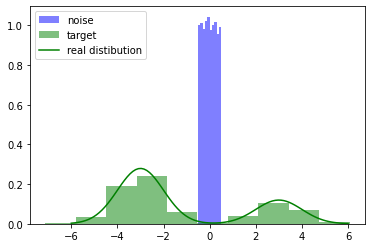

In [85]:
plot_gan_data(data_fn, noise_fn, data_pdf)

In [86]:
gen_hiddens = [1, 64, 64, 64, 1]
dis_hiddens = [1, 64, 64, 64, 1]
G = get_simple_model(gen_hiddens)
D = nn.Sequential(*get_simple_model(dis_hiddens), nn.Sigmoid())

gan = VanillaGAN(G, D, noise_fn, data_fn, device='cpu')
loss_g, loss_d_real, loss_d_fake = [], [], []

In [87]:
epochs = 20
batches = 100

In [90]:
start = time()
for epoch in range(epochs):
    break
    loss_g_running, loss_d_real_running, loss_d_fake_running = 0, 0, 0
    for i,batch in enumerate(range(batches)):
        lg_, (ldr_, ldf_) = gan.train_step()
        loss_g_running += lg_
        loss_d_real_running += ldr_
        loss_d_fake_running += ldf_
    loss_g.append(loss_g_running / batches)
    loss_d_real.append(loss_d_real_running / batches)
    loss_d_fake.append(loss_d_fake_running / batches)
    print(f"Epoch {epoch+1}/{epochs} ({int(time() - start)}s):"
          f" G={loss_g[-1]:.3f},"
          f" Dr={loss_d_real[-1]:.3f},"
          f" Df={loss_d_fake[-1]:.3f}")
    visualize_GAN(gan, data_pdf=data_pdf)